In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline 

## Load and prepare dataset

In [2]:
df_raw = pd.read_csv("../assets/Churn_Predictor.csv")

In [3]:
df_raw.head()

,client_id,client_Type,status,churned,survived,segment,segment_rank,provisioning_date_initial,live_date_initial,termination_date,days_active_range,days_active,completed_csc_ind,yodle_package_initial_provisioning,monthly_recurring_revenue_initial,contractlength,last_login,total_logins,total_leads,total_spend
0,89456,Local,LIVE,0,1,Lawyer,3,2/17/2012,2/22/2012,9/26/2015,181+,1648.0,0,Yodle_Max,1249.0,THREE_MONTH,8/25/2016,5,570,7536.00
1,107293,Local,LIVE,0,1,HVAC Contractor,>5,6/20/2012,6/25/2012,12/25/2014,181+,1524.0,0,Yodle_Max,1249.0,THREE_MONTH,5/16/2016,6,812,0.00
2,95932,Local,OFF,1,0,Lawyer,3,6/15/2015,6/15/2015,8/28/2015,61-90,74.0,0,Yodle_Max,699.0,THREE_MONTH,8/13/2015,14,216,391.13
3,79900,Local,LIVE,0,1,Flooring Contractor,>5,9/7/2011,9/7/2011,12/7/2014,181+,1816.0,0,Yodle_Organic,145.0,NO_CONTRACT,NaN,0,1029,0.00
4,105070,Local,LIVE,0,1,Roofer,5,5/31/2012,5/31/2012,2/28/2015,181+,1549.0,0,Yodle_Organic,145.0,NO_CONTRACT,8/3/2016,35,215,0.00


In [4]:
cols_to_remove = ["client_id", "client_Type","client_type","status","segment","segment_rank","provisioning_date_initial",
                  "live_date_initial","termination_date","days_active","days_active_range","completed_csc_ind",
                  "contractlength","last_login","total_logins","churned"]

df = df_raw[[c for c in df_raw.columns if c not in cols_to_remove]]

In [5]:
df.head()

,survived,yodle_package_initial_provisioning,monthly_recurring_revenue_initial,total_leads,total_spend
0,1,Yodle_Max,1249.0,570,7536.00
1,1,Yodle_Max,1249.0,812,0.00
2,0,Yodle_Max,699.0,216,391.13
3,1,Yodle_Organic,145.0,1029,0.00
4,1,Yodle_Organic,145.0,215,0.00


In [6]:
print df.shape
df.describe()

(53349, 5)


,survived,monthly_recurring_revenue_initial,total_leads,total_spend
count,53349.000000,53349.000000,53349.000000,53349.000000
mean,0.364337,371.544167,144.308834,550.290725
std,0.481248,403.121716,535.407105,2853.118619
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,199.000000,10.000000,0.000000
50%,0.000000,249.000000,32.000000,0.000000
75%,1.000000,299.000000,105.000000,0.000000
max,1.000000,35049.000000,43549.000000,442214.680000


In [7]:
for c in df.columns:
    print(c, len(df[df[c].isnull()]))

('survived', 0)
('yodle_package_initial_provisioning', 172)
('monthly_recurring_revenue_initial', 0)
('total_leads', 0)
('total_spend', 0)


In [8]:
df = df.dropna() 
print df.count()

survived                              53177
yodle_package_initial_provisioning    53177
monthly_recurring_revenue_initial     53177
total_leads                           53177
total_spend                           53177
dtype: int64


In [9]:
df.describe()

,survived,monthly_recurring_revenue_initial,total_leads,total_spend
count,53177.000000,53177.000000,53177.000000,53177.000000
mean,0.365496,371.788043,144.762266,552.070456
std,0.481574,403.584691,536.209397,2857.557259
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,199.000000,10.000000,0.000000
50%,0.000000,249.000000,32.000000,0.000000
75%,1.000000,299.000000,106.000000,0.000000
max,1.000000,35049.000000,43549.000000,442214.680000


## Exploratory Data Analysis

### Frequency table

In [10]:
pd.crosstab(df['survived'],df['yodle_package_initial_provisioning'],rownames=['survived'],)

yodle_package_initial_provisioning,Yodle_Ads,Yodle_Max,Yodle_Organic,Yodle_Web_Only
survived,,,,
0,194,5573,27964,10
1,176,3010,16245,5


### Plots

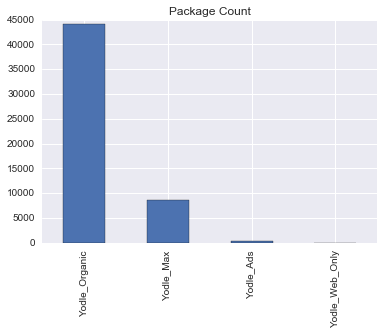

In [11]:
df.yodle_package_initial_provisioning.value_counts().plot(kind='bar', title ="Package Count")

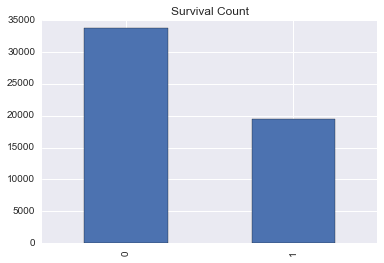

In [12]:
df.survived.value_counts().plot(kind='bar', title="Survival Count")

(0, 500)

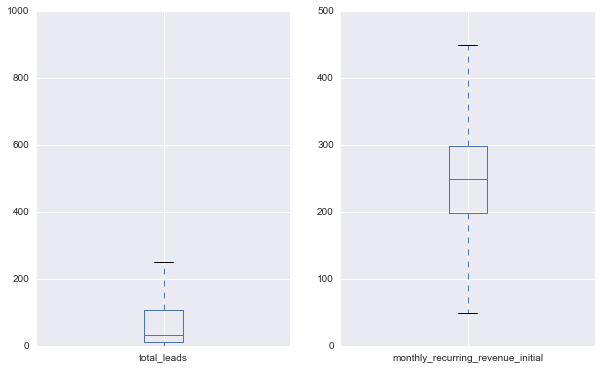

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

df.total_leads.plot(kind="box", ax=axs[0])
axs[0].set_ylim([0, 1000])

df.monthly_recurring_revenue_initial.plot(kind="box", ax=axs[1])
axs[1].set_ylim([0, 500])

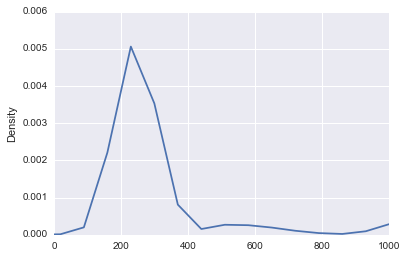

In [14]:
df.monthly_recurring_revenue_initial.plot(kind='density', xlim=(0,1000))

,survived,monthly_recurring_revenue_initial,total_leads,total_spend
survived,1.000000,-0.004035,0.125501,0.048884
monthly_recurring_revenue_initial,-0.004035,1.000000,0.107255,0.585837
total_leads,0.125501,0.107255,1.000000,0.217169
total_spend,0.048884,0.585837,0.217169,1.000000


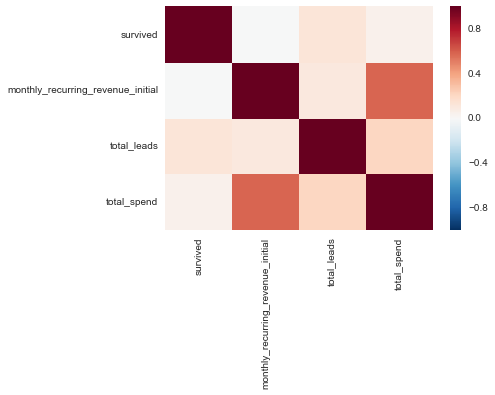

In [15]:
sns.heatmap(df.corr())
df.corr()

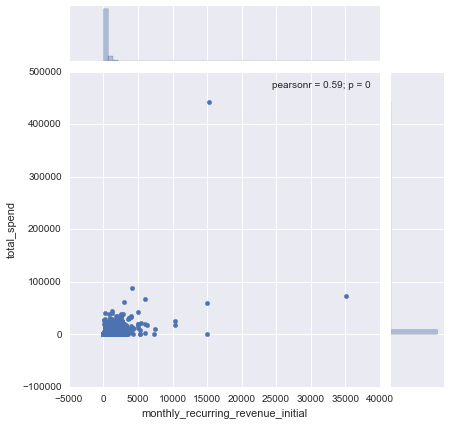

In [16]:
sns.jointplot('monthly_recurring_revenue_initial','total_spend', data=df)

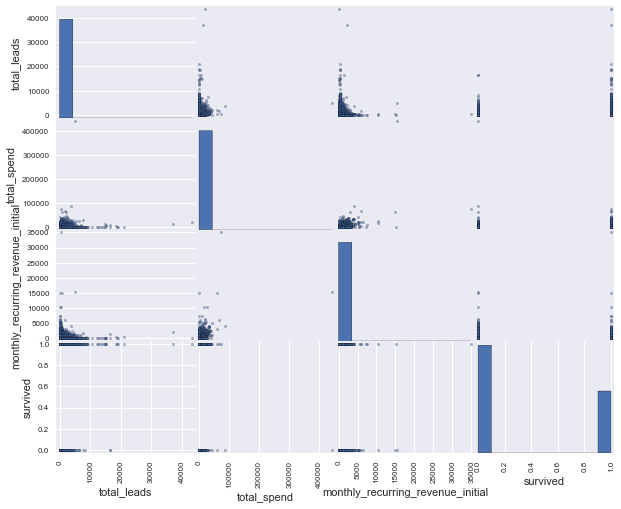

In [17]:
pd.scatter_matrix(df[['total_leads','total_spend','monthly_recurring_revenue_initial','survived']], figsize=(10,8))
plt.show()

In [18]:
X = df[['total_leads']]
y = df['total_spend']

lm = smf.ols(formula='y ~ X', data=df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2632.
Date:                Sun, 28 Aug 2016   Prob (F-statistic):               0.00
Time:                        16:34:02   Log-Likelihood:            -4.9734e+05
No. Observations:               53177   AIC:                         9.947e+05
Df Residuals:                   53175   BIC:                         9.947e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    384.5322     12.529     30.691      0.000       359.975   409.090
X              1.1573      0.023     51.303      0.000         1.113     1.202
==============================================================================
Omnibus:                   193076.792   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     281900693570.459
Skew:                          75.341   Prob(JB):                         0.00
Kurtosis:                   11281.544   Cond. No.                         575.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

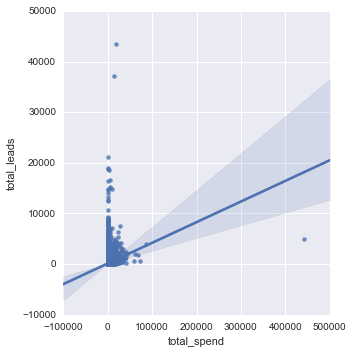

In [19]:
sns.lmplot('total_spend', 'total_leads', df_raw)

## Calculating Odds Ratio

In [20]:
df.head()

,survived,yodle_package_initial_provisioning,monthly_recurring_revenue_initial,total_leads,total_spend
0,1,Yodle_Max,1249.0,570,7536.00
1,1,Yodle_Max,1249.0,812,0.00
2,0,Yodle_Max,699.0,216,391.13
3,1,Yodle_Organic,145.0,1029,0.00
4,1,Yodle_Organic,145.0,215,0.00


In [21]:
df = df.join(pd.get_dummies(df.yodle_package_initial_provisioning).drop('Yodle_Web_Only',axis=1))

In [22]:
df.head()

,survived,yodle_package_initial_provisioning,monthly_recurring_revenue_initial,total_leads,total_spend,Yodle_Ads,Yodle_Max,Yodle_Organic
0,1,Yodle_Max,1249.0,570,7536.00,0.0,1.0,0.0
1,1,Yodle_Max,1249.0,812,0.00,0.0,1.0,0.0
2,0,Yodle_Max,699.0,216,391.13,0.0,1.0,0.0
3,1,Yodle_Organic,145.0,1029,0.00,0.0,0.0,1.0
4,1,Yodle_Organic,145.0,215,0.00,0.0,0.0,1.0


In [106]:
#calculate odds for an organic package
k = pd.crosstab(df.survived, df.yodle_package_initial_provisioning, rownames=['survived']).iloc[:, 2:3]
k

yodle_package_initial_provisioning,Yodle_Organic
survived,
0,27964
1,16245


In [107]:
#calculate odds of surviving if you are an organic package
round(sum(k.loc[1])/float(sum(k.loc[0])),2)

0.58

In [108]:
#calculate odds if you are ads package
k = pd.crosstab(df.survived, df.yodle_package_initial_provisioning, rownames=['survived']).iloc[:, 0:1]
k

yodle_package_initial_provisioning,Yodle_Ads
survived,
0,194
1,176


In [109]:
#calculate odds
round(sum(k.loc[1])/float(sum(k.loc[0])),2)

0.91

In [110]:
#calculate odds ratio
0.6/0.93

0.6451612903225806

## Regression Analysis

In [111]:
#manually add intercept
df['intercept'] = 1.0 
data = df
data.head()

,survived,yodle_package_initial_provisioning,monthly_recurring_revenue_initial,total_leads,total_spend,Yodle_Ads,Yodle_Max,Yodle_Organic,intercept
0,1,Yodle_Max,1249,570,7536,0,1,0,1.0
1,1,Yodle_Max,1249,812,0,0,1,0,1.0
2,0,Yodle_Max,699,216,391,0,1,0,1.0
3,1,Yodle_Organic,145,1029,0,0,0,1,1.0
4,1,Yodle_Organic,145,215,0,0,0,1,1.0


In [112]:
# set covariates to a variable called train_cols
train_cols = data.columns[2:]

logit = sm.Logit(data['survived'], data[train_cols])

In [113]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.641382
         Iterations 6


In [114]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                53177
Model:                          Logit   Df Residuals:                    53170
Method:                           MLE   Df Model:                            6
Date:                Mon, 29 Aug 2016   Pseudo R-squ.:                 0.02305
Time:                        14:26:23   Log-Likelihood:                -34107.
converged:                       True   LL-Null:                       -34912.
                                        LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
monthly_recurring_revenue_initial    -0.0002   4.82e-05     -4.290      0.000        -0.000    -0.000
total_leads                           0.0011   3.96e-05     28

In [115]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                                       2.5%     97.5%        OR
monthly_recurring_revenue_initial  0.999699  0.999888  0.999793
total_leads                        1.001034  1.001189  1.001111
total_spend                        1.000034  1.000063  1.000049
Yodle_Ads                          0.583243  5.898951  1.854865
Yodle_Max                          0.368775  3.592179  1.150959
Yodle_Organic                      0.469439  4.554789  1.462257
intercept                          0.118840  1.153751  0.370285


## Classification with Logistic Regression

In [116]:
df.groupby('Yodle_Organic').size()

Yodle_Organic
0     8968
1    44209
dtype: int64

In [117]:
df.head()

,survived,yodle_package_initial_provisioning,monthly_recurring_revenue_initial,total_leads,total_spend,Yodle_Ads,Yodle_Max,Yodle_Organic,intercept
0,1,Yodle_Max,1249,570,7536,0,1,0,1.0
1,1,Yodle_Max,1249,812,0,0,1,0,1.0
2,0,Yodle_Max,699,216,391,0,1,0,1.0
3,1,Yodle_Organic,145,1029,0,0,0,1,1.0
4,1,Yodle_Organic,145,215,0,0,0,1,1.0


In [118]:
#use these features for classification
features  = ['monthly_recurring_revenue_initial','total_leads','total_spend','Yodle_Ads','Yodle_Max','Yodle_Organic']

In [119]:
df.head()

,survived,yodle_package_initial_provisioning,monthly_recurring_revenue_initial,total_leads,total_spend,Yodle_Ads,Yodle_Max,Yodle_Organic,intercept
0,1,Yodle_Max,1249,570,7536,0,1,0,1.0
1,1,Yodle_Max,1249,812,0,0,1,0,1.0
2,0,Yodle_Max,699,216,391,0,1,0,1.0
3,1,Yodle_Organic,145,1029,0,0,0,1,1.0
4,1,Yodle_Organic,145,215,0,0,0,1,1.0


In [120]:
lr = LogisticRegression()
lr.fit(df[features], df.survived)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [121]:
X, y = df[features], df.survived

In [122]:
#use k-fold cross validation with k=10
#calculate mean test set accuracy of LogisticRegression using all features to predict survival
kf = KFold(len(df),n_folds=10,shuffle=True)
scores = []

for train, test in kf:
    
    Xtrain = X.iloc[train]
    ytrain = y.iloc[train]
    Xtest = X.iloc[test]
    ytest = y.iloc[test]
    
    lr = LogisticRegression()
    lr.fit(Xtrain, ytrain)
    
    scores.append(lr.score(Xtest, ytest))
    
print np.mean(scores)

0.65272579321


In [123]:
for tr, te in kf:
    print(len(tr), len(te))

(47859, 5318)
(47859, 5318)
(47859, 5318)
(47859, 5318)
(47859, 5318)
(47859, 5318)
(47859, 5318)
(47860, 5317)
(47860, 5317)
(47860, 5317)


In [124]:
scores

[0.6515607371192178,
 0.64422715306506206,
 0.6632192553591576,
 0.66133884919142538,
 0.65137269650244456,
 0.6434749905979692,
 0.65438134637081613,
 0.65243558397592627,
 0.65694940756065445,
 0.64829791235659207]

## Classifiction with KNN

In [130]:
params = {'n_neighbors': range(3,10,2),
          'weights': ['distance']}
gs = GridSearchCV(KNeighborsClassifier(),params,cv=kf)
gs.fit(df[features],df.survived)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=53177, n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9], 'weights': ['distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)